# Ch-7 Random Forest 

In [1]:
# SETTING UP:
import os
import time
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## Voting Classifiers:

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X,y=make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


Hard voting:

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [4]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Soft voting:

In [6]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [7]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


Soft voting gave us a higher accuracy score due to it giving higher weight to the more *confident* votes.

## Bagging and Pasting:

In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf=BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred=bag_clf.predict(X_test)


In [9]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))


0.92


In [10]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


We can see how the accuracy of the bagging classifier is higher than that of the decision tree!

## Out-of-Bag classifier:

In [11]:
bag_clf=BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, bootstrap=True, n_jobs=-1, oob_score=True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8933333333333333

In [12]:
y_pred=bag_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.92

Close enough!

With oob we got more accuracy

In [13]:
bag_clf.oob_decision_function_

array([[0.39411765, 0.60588235],
       [0.35897436, 0.64102564],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08433735, 0.91566265],
       [0.37125749, 0.62874251],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.97311828, 0.02688172],
       [0.75609756, 0.24390244],
       [0.        , 1.        ],
       [0.72772277, 0.27227723],
       [0.83243243, 0.16756757],
       [0.96216216, 0.03783784],
       [0.04255319, 0.95744681],
       [0.00564972, 0.99435028],
       [1.        , 0.        ],
       [0.91256831, 0.08743169],
       [0.9947644 , 0.0052356 ],
       [0.01595745, 0.98404255],
       [0.32828283, 0.67171717],
       [0.91935484, 0.08064516],
       [1.        , 0.        ],
       [0.97252747, 0.02747253],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.60487805, 0.39512195],
       [0.

This gave us the class probabilities of each training instance.

In [14]:
from sklearn.metrics import accuracy_score

y_pred=bag_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.92

## Random Patches and Random Subspaces:

### Random Forests:

In [15]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf=RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train,y_train)

y_pred_rf=rnd_clf.predict(X_test)


In [16]:
np.sum(y_pred == y_pred_rf) / len(y_pred)   #where y_pred is from bag_clf

0.928

### Feature Importance:

In [17]:
from sklearn.datasets import load_iris

iris=load_iris()
rnd_clf=RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

rnd_clf.fit(iris["data"], iris["target"])

for name,score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)


sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


Doing the same for the MNIST dataset:

In [18]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [19]:
rnd_clf_mnist=RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rnd_clf_mnist.fit(mnist["data"], mnist["target"])


RandomForestClassifier(n_jobs=-1, random_state=42)

In [20]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


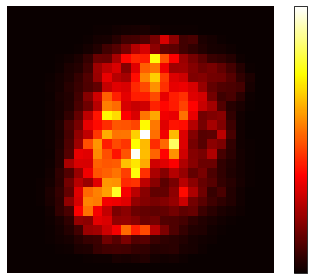

In [21]:
plot_digit(rnd_clf_mnist.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

## Boosting:

### AdaBoost:

In [22]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME.R", learning_rate=0.5)

ada_clf.fit(X_train, y_train)




AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### Gradient Boosting:

In [23]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [24]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1=DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

Now we train 2 decision tree regressors on the residual errors of the last ones!

In [25]:
y2=y-tree_reg1.predict(X)
tree_reg2=DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [26]:
y3=y2-tree_reg2.predict(X)
tree_reg3=DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [27]:
X_new = np.array([[0.8]])


In [28]:
y_pred=sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [29]:
y_pred

array([0.75026781])

In [30]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt=GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1)

gbrt.fit(X,y)


GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3)

In [31]:
gbrt.predict(X_new)

array([0.75026781])

Gradient boost with early stopping:

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train,X_test,y_train, y_test= train_test_split(X,y)

gbrt=GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train,y_train)

errors=[mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]
best_n_estimators=np.argmin(errors)+1  #since it'll start from 0

gbrt_best=GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=85)

Using early stopping by stopping the training earlier (faster):

In [33]:
gbrt=GradientBoostingRegressor(max_depth=2, warm_start=True)  #warm_start is what tells the method to do incremental training

min_val_error=float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [34]:
print(gbrt.n_estimators)


69


In [35]:
print("Minimum validation MSE:", min_val_error)


Minimum validation MSE: 0.002750279033345716


In [36]:
import xgboost
xgb_reg=xgboost.XGBRegressor()
xgb_reg.fit(X_train,y_train)

y_pred=xgb_reg.predict(X_test)



In [37]:
y_pred

array([ 0.4715256 ,  0.3437669 , -0.06564816,  0.14064051,  0.21580112,
        0.70629996,  0.01889667,  0.12487141,  0.03672805,  0.18667978,
        0.63876384,  0.28322217,  0.37638247,  0.5400119 ,  0.21580112,
        0.18667978,  0.6062498 ,  0.36969078,  0.70629996,  0.17365755,
        0.16903733,  0.14076371,  0.4427203 ,  0.70629996,  0.14064051],
      dtype=float32)

In [38]:
mean_squared_error(y_test, y_pred)

0.003684854933316534

### We use MSE for Regression tasks and accuracy_score for Classification tasks


## Questions:

### Q8:

In [43]:
X_train_val, X_test, y_train_val, y_test=train_test_split(mnist["data"], mnist["target"], test_size=10000, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=10000, random_state=42)


In [44]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier  #(??)

In [47]:
random_forest=RandomForestClassifier(n_estimators=100, random_state=42)
extra_trees=ExtraTreesClassifier(n_estimators=100, random_state=42)
svm=SVC(kernel="linear", max_iter=100, tol=20, random_state=42)
mlp=MLPClassifier(random_state=42)

In [48]:
estimators = [random_forest, extra_trees, svm, mlp]
for estimator in estimators:
    print("Training the", estimator)
    estimator.fit(X_train, y_train)

Training the RandomForestClassifier(random_state=42)
Training the ExtraTreesClassifier(random_state=42)
Training the SVC(kernel='linear', max_iter=100, random_state=42, tol=20)
Training the MLPClassifier(random_state=42)


In [50]:
for i in estimators:
    print(i, "score is: ", i.score(X_val, y_val))   #just printing their scores!

RandomForestClassifier(random_state=42) score is:  0.9692
ExtraTreesClassifier(random_state=42) score is:  0.9715
SVC(kernel='linear', max_iter=100, random_state=42, tol=20) score is:  0.0956
MLPClassifier(random_state=42) score is:  0.9617


In [51]:
from sklearn.ensemble import VotingClassifier

voting_clf_hard=VotingClassifier(estimators=[('RandomForest', random_forest),('ExtraTrees', extra_trees),('SVC_linear',svm),('mlp', mlp)], voting="hard")
voting_clf_soft=VotingClassifier(estimators=[('RandomForest', random_forest),('ExtraTrees', extra_trees),('SVC_linear',svm),('mlp', mlp)], voting="soft")


In [52]:
voting_clf_hard.fit(X_train, y_train)

VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(random_state=42)),
                             ('ExtraTrees',
                              ExtraTreesClassifier(random_state=42)),
                             ('SVC_linear',
                              SVC(kernel='linear', max_iter=100,
                                  random_state=42, tol=20)),
                             ('mlp', MLPClassifier(random_state=42))])

In [54]:
voting_clf_soft.fit(X_train, y_train)

VotingClassifier(estimators=[('RandomForest',
                              RandomForestClassifier(random_state=42)),
                             ('ExtraTrees',
                              ExtraTreesClassifier(random_state=42)),
                             ('SVC_linear',
                              SVC(kernel='linear', max_iter=100,
                                  random_state=42, tol=20)),
                             ('mlp', MLPClassifier(random_state=42))],
                 voting='soft')

In [57]:
voting_clf_hard.score(X_val, y_val)

0.9732

In [60]:
#voting_clf_soft.score(X_val,y_val)

In [62]:
voting_clf_hard.score(X_test, y_test)

0.9707

In [63]:
voting_clf_hard.voting="soft"

We see that the hard classifier performs worse than soft one.

### Q9:

In [65]:
X_val_predictions = np.empty((len(X_val), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_val_predictions[:, index] = estimator.predict(X_val)

In [66]:
X_val_predictions


array([[5., 5., 9., 5.],
       [8., 8., 9., 8.],
       [2., 2., 9., 2.],
       ...,
       [7., 7., 9., 7.],
       [6., 6., 9., 6.],
       [7., 7., 9., 7.]], dtype=float32)

In [67]:
rnd_forest_blender = RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)
rnd_forest_blender.fit(X_val_predictions, y_val)

RandomForestClassifier(n_estimators=200, oob_score=True, random_state=42)

In [68]:
rnd_forest_blender.oob_score_


0.9708

In [69]:
X_test_predictions = np.empty((len(X_test), len(estimators)), dtype=np.float32)

for index, estimator in enumerate(estimators):
    X_test_predictions[:, index] = estimator.predict(X_test)

In [70]:
y_pred = rnd_forest_blender.predict(X_test_predictions)


In [71]:
accuracy_score(y_test, y_pred)


0.9687